<a href="https://colab.research.google.com/github/nusc2016/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/Module2/Aaron_Huizenga_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [169]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [171]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [0]:
# Before I begin my work, I want to import what I will need just like I did 
# on Module 1

import numpy as np
import plotly.express as px
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

## Define a function to wrangle train, validation, and test sets in the same way. Clean outliers and engineer new features

In [173]:
# Split the training data into training and validation dfs
train, val = train_test_split(train, train_size=0.8, test_size=0.2, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
# I don't like running a large cell, but when trying to do this separately, the 
# OCD in me kept telling me that it's not going to work. I kept getting errors 
# telling me that "X" wasn't defined. So I have grouped these all together in 
# one cell. Let's hope it works this time

def wrangle(X):
        
    # I want to prevent another 'SettingWithCopy' warning.
    X = X.copy()
    

    # Outside Tanzania, latitude has some seriously small values close to zero,
    # so I want to basically treat them as if they were zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Like I did yesterday I want to replace the zeros with nulls and then impute
    # the missing values later down the line. I will also create a "missing indicator"
    # column.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # This function will drop the duplicate columns
    
    X = X.drop(columns=['quantity_group', 'extraction_type_group', 'payment_type',
                      'source_type', 'waterpoint_type_group'])
    
    # I need to convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year

    # Drop the date_recorded column 
    X = X.drop(columns='date_recorded')

    # I want to install an engineer feature of how many years from construction_year
    # to date_recorded.
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()

    # This function will return the wrangled data
    return X

    train = wrangle(train)
    val = wrangle(val)
    test = wrangle(test)

In [0]:
# The target is going to be 'status_group'

target = 'status_group'

In [0]:
# Drop target columns from train and validation data sets

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test

In [178]:
# I saw this used in today's lecture and wanted to include it here. 

%%time

# This pipeline is identical to the example cell above,
# except we're replacing one-hot encoder with "ordinal" encoder
pipeline = make_pipeline(ce.OrdinalEncoder(), SimpleImputer(strategy='median'), 
     RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,
                            min_samples_leaf=2, min_weight_fraction_leaf=0.0,
                            max_features='auto', max_leaf_nodes=1000, min_impurity_decrease=0.0,
                            min_impurity_split=None, random_state=125, n_jobs=-1))


# This function will fit train and score value

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7987373737373737
CPU times: user 2min 16s, sys: 423 ms, total: 2min 17s
Wall time: 1min 14s


In [179]:
print('X_train shape before encoding', X_train.shape)

encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train)
print('X_train shape after encoding', encoded.shape)

X_train shape before encoding (47520, 40)
X_train shape after encoding (47520, 40)


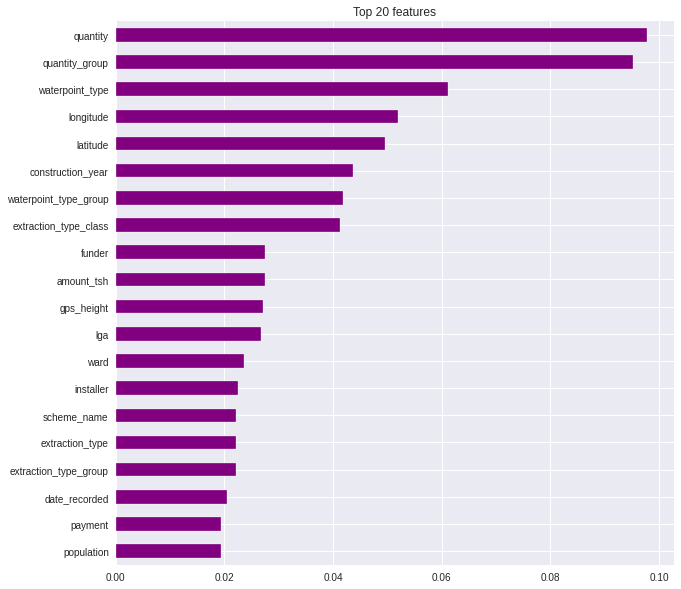

In [180]:
# This function will bot get and plot top 20 feature importances

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, encoded.columns)

n = 20 
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color="purple");

### I wanted to play around with something I found in looking around on different types of plots, and as the title suggests, it is exactly what it says "Confusion"

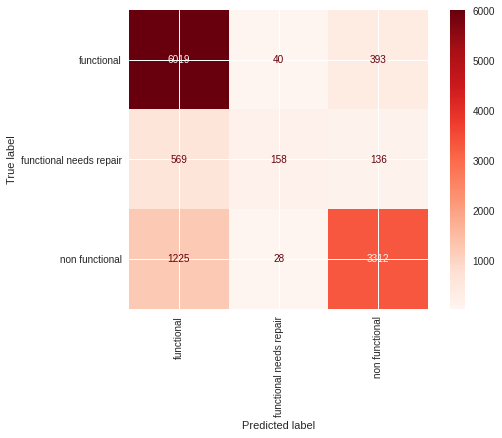

In [156]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.0f',
                      cmap='Reds');

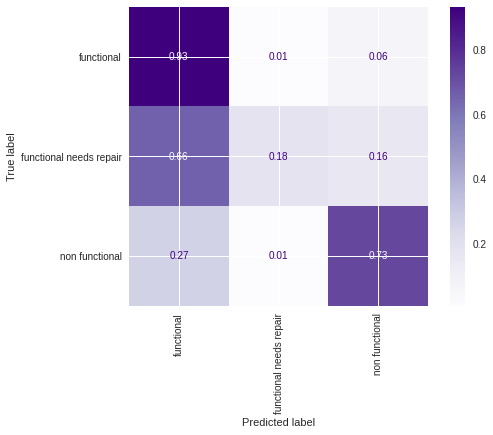

In [157]:
# All I did different on this cell was with the addition of "normalize=True"

plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='vertical', 
                      normalize='true',
                      values_format='.2f',
                      cmap='Purples');

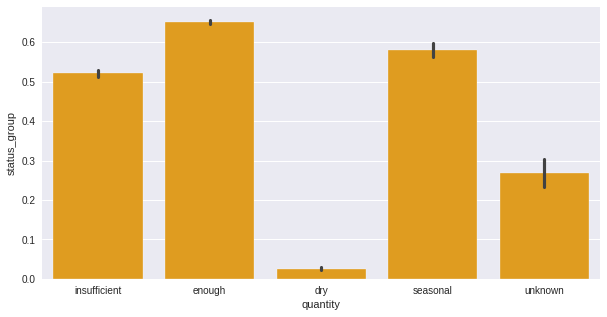

In [183]:
feature = 'quantity'

import seaborn as sns
plt.figure(figsize=(10,5))
sns.barplot(x=train[feature], y=train['status_group']=='functional',
    color='orange')

In [184]:
# STRETCH: Check out how onehotencoder would change validation accuracy

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 150
categorical_features = cardinality[cardinality <= 150].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Isolate all train and test datasets by features columns
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

# Import class
import category_encoders as ce

# Make the pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train/Score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy after OneHotEncoding:', pipeline.score(X_val, y_val))

Validation Accuracy after OneHotEncoding: 0.8027777777777778


In [0]:
# I will use the next function to run a predict on test

y_pred = pipeline.predict(X_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv("Aaron_Huizenga2.csv", index=False)

In [0]:
from google.colab import files
files.download('Aaron_Huizenga2.csv')